In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("..")

from utils.funciones_toolbox_ml_final import *
from utils.modulos import *

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, recall_score, balanced_accuracy_score, make_scorer, precision_recall_curve, roc_curve, auc
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from joblib import dump



## Problema de negocio

El síndrome metabólico es un conjunto de condiciones médicas que aumentan el riesgo de enfermedades cardiovasculares, diabetes tipo 2 y otros problemas de salud. Estas condiciones incluyen hipertensión arterial, niveles altos de azúcar en la sangre, exceso de grasa abdominal y niveles anormales de colesterol o triglicéridos en la sangre, por lo que se nos pide:

**Identificar a las personas en riesgo para crear posteriormente programas de salud e intervenciones preventivas y personalizadas para éstos pacientes**

## Objetivo técnico

- Crear un modelo supervisado de clasificación

## Métricas

 - El recall de la clase 1 sería la métrica adecuada para evaluar qué tan bien el modelo identifica a todos los pacientes que tienen el síndrome metabólico, donde la clase positiva representa a los pacientes enfermos (clase 1). Al establecer el recall como la métrica objetivo, se prioriza la capacidad del modelo para detectar a todos los pacientes con síndrome metabólico. Esto asegura que el modelo esté optimizado para capturar la mayor cantidad posible de casos positivos, lo que es crucial para identificar a las personas en riesgo y proporcionarles la atención médica adecuada.

## Obtención de los datos

In [3]:
df = pd.read_csv("../data/MetabolicSyndrome.csv")
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,0
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,0
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,0
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,0
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 281.5+ KB


In [5]:
describe_df(df)

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
Tipo,int64,int64,object,object,float64,object,float64,float64,int64,float64,float64,int64,int64,int64,int64
Porcentaje_Nulos,0.0,0.0,0.0,8.663057,4.87297,0.0,3.540192,1.082882,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores_Unicos,2401,61,2,5,14,6,635,322,3,1383,88,187,93,345,2
Porcentaje_Cardinalidad,100.0,2.540608,0.083299,0.208247,0.58309,0.249896,26.447314,13.411079,0.124948,57.601,3.66514,7.788421,3.873386,14.369013,0.083299


In [6]:
tabla_descriptiva = tipifica_variables(df,10,30)
tabla_descriptiva

,nombre_variable,tipo_sugerido
0,seqn,Numerica Continua
1,Age,Numerica Discreta
2,Sex,Binaria
3,Marital,Categorica
4,Income,Numerica Discreta
5,Race,Categorica
6,WaistCirc,Numerica Discreta
7,BMI,Numerica Discreta
8,Albuminuria,Categorica
9,UrAlbCr,Numerica Continua


In [7]:
descripcion = {"Descripcion":["Índice único", "Edad", "Género", 
                              "Estado civil","Ingresos", "Raza",
                              "Circunferencia Abdominal", "Índice de Masa Corporal",
                              "Medida de Albumina en orina", "Relación Albumina-Creatitina en orina",
                              "Ácido Úrico", "Azúcar en sangre", 
                              "Niveles de colesterol de lipoproteínas de alta densidad('colesterol bueno')",
                              "Triglicéridos", "Indica la presencia (1) o ausencia (0) de síndrome metabólico"
                              ]}
df_descripcion = pd.DataFrame(descripcion)

tabla_descriptiva = pd.concat([tabla_descriptiva, df_descripcion], axis=1)

In [8]:
tabla_descriptiva
tabla_descriptiva

,nombre_variable,tipo_sugerido,Descripcion
0,seqn,Numerica Continua,Índice único
1,Age,Numerica Discreta,Edad
2,Sex,Binaria,Género
3,Marital,Categorica,Estado civil
4,Income,Numerica Discreta,Ingresos
5,Race,Categorica,Raza
6,WaistCirc,Numerica Discreta,Circunferencia Abdominal
7,BMI,Numerica Discreta,Índice de Masa Corporal
8,Albuminuria,Categorica,Medida de Albumina en orina
9,UrAlbCr,Numerica Continua,Relación Albumina-Creatitina en orina


- Voy a eliminar las columnas que no me aportan nada a la hora de realizar el modelo, "seqn" porque es un índice de los pacientes y tiene una cardinalidad del 100%, y elimino "UrAlbCr" porque aporta la misma información que Albuminuria.

In [9]:
df.drop(columns=["seqn", "UrAlbCr"], inplace= True)

In [10]:
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- Hay 4 columnas con valores nulos, de las cuales "Marital" es la única categórica.

In [11]:
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,2954.032186,16.252634,6.662242,0.422780,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


In [12]:
# Verificamos que no hayan duplicados
print(df.duplicated().sum())

0


## Separar en Train y Test

In [13]:
train_set, test_set = train_test_split(df, test_size=0.2, stratify= df["MetabolicSyndrome"],random_state=73)

In [14]:
train_set["MetabolicSyndrome"].value_counts()

MetabolicSyndrome
0    1263
1     657
Name: count, dtype: int64

In [15]:
test_set["MetabolicSyndrome"].value_counts()

MetabolicSyndrome
0    316
1    165
Name: count, dtype: int64

## Mini EDA

#### Definimos el target

In [16]:
target = "MetabolicSyndrome"

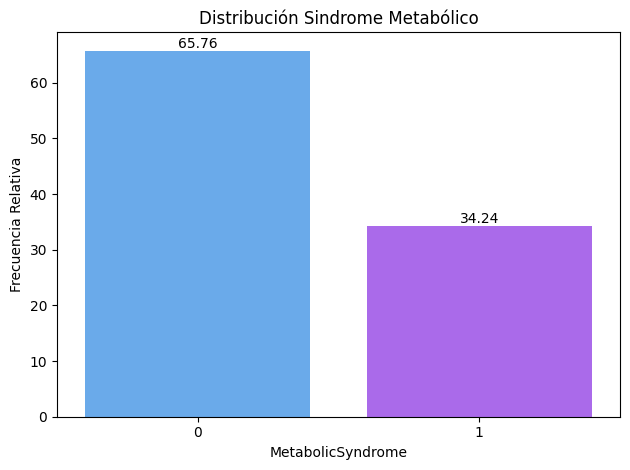

In [17]:
barplot_categorica(df, target)

- El target está desbalanceado, hay mayor concentración de pacientes hacía la clase 0 es decir los pacientes sanos, tendré que tener éste factor en cuenta a la hora de realizar el modelo porque lo que nos interesa conseguir es la mayor precisión en el grupo 1.

In [18]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1920 entries, 651 to 1230
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1920 non-null   int64  
 1   Sex                1920 non-null   object 
 2   Marital            1746 non-null   object 
 3   Income             1821 non-null   float64
 4   Race               1920 non-null   object 
 5   WaistCirc          1858 non-null   float64
 6   BMI                1902 non-null   float64
 7   Albuminuria        1920 non-null   int64  
 8   UricAcid           1920 non-null   float64
 9   BloodGlucose       1920 non-null   int64  
 10  HDL                1920 non-null   int64  
 11  Triglycerides      1920 non-null   int64  
 12  MetabolicSyndrome  1920 non-null   int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 210.0+ KB


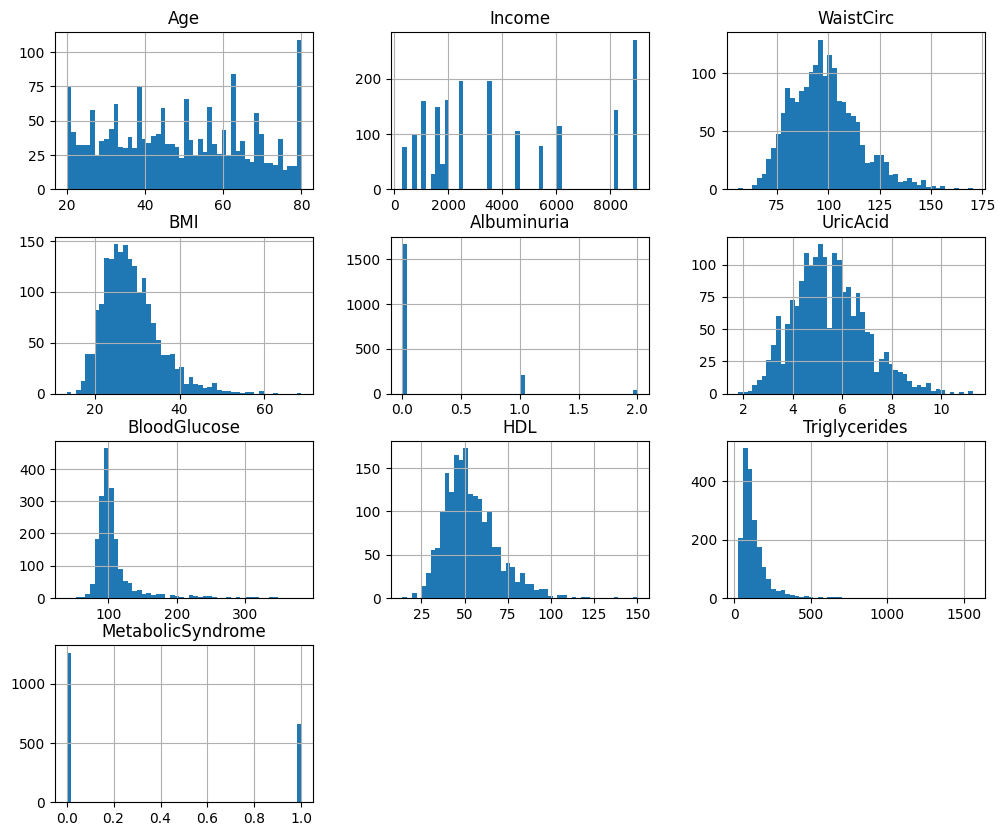

In [19]:
train_set.hist(bins=50, figsize=(12, 10))
plt.show()

- Voy a empezar por imputar nulos a las columnas:

    - Marital: Moda
    - Income: Media
    - WaistCirc: Media
    - BMI:Media                   

In [20]:
waist_circ_media = train_set["WaistCirc"].mean()
bmi_media = train_set["BMI"].mean()
income_media = train_set["Income"].mean()
marital_moda = train_set["Marital"].mode()[0]
train_set["WaistCirc"].fillna(waist_circ_media, inplace=True)
train_set["BMI"].fillna(waist_circ_media, inplace=True)
train_set["Income"].fillna(income_media, inplace = True)
train_set["Marital"].fillna(marital_moda, inplace = True)

- Hago lo mismo al test

In [21]:
test_set["WaistCirc"].fillna(waist_circ_media, inplace=True)
test_set["BMI"].fillna(waist_circ_media, inplace=True)
test_set["Income"].fillna(income_media, inplace = True)
test_set["Race"].fillna(marital_moda, inplace = True)

- Como ya he realizado el EDA anteriormente, sé que hay features que tiene muchos outliers por lo que voy a categorizarlas para poder tratar esos valores atípicos y mejorar la compresión de los datos, seguimos los valores médicos estándar para hacer las categorizaciones.

- Enlace al EDA:
https://github.com/nessapatino/EDA_METABOLICSYNDROME

In [22]:
ou= ["BMI","WaistCirc","BloodGlucose","HDL","Triglycerides"]

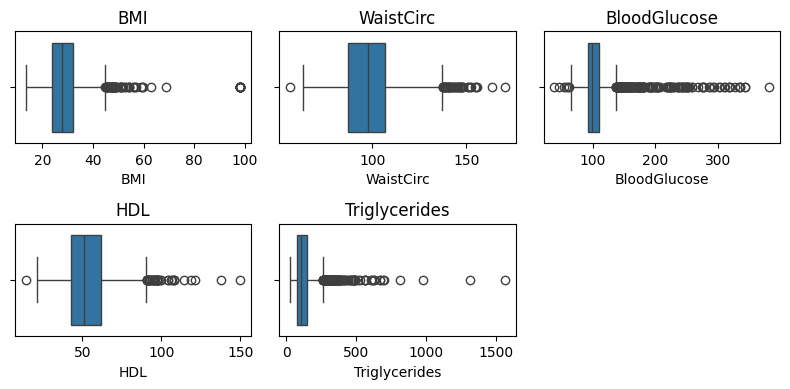

In [23]:
plt.figure(figsize=(8,4))  # Ajusta el tamaño de la figura

for i, columna in enumerate(ou, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=train_set[columna])
    plt.title(columna)

# Ajustar el diseño
plt.tight_layout()

# Mostrar los boxplots
plt.show()

In [24]:
#Categorizar BMI
bins = [-np.inf, 18.5, 24.9, 29.9, np.inf]
labels = ['Bajo peso', 'Normal', 'Sobrepeso', 'Obesidad']
train_set['categoria_bmi'] = pd.cut(train_set["BMI"], bins=bins, labels=labels)
print(train_set['categoria_bmi'].value_counts())

categoria_bmi
Obesidad     700
Sobrepeso    610
Normal       575
Bajo peso     35
Name: count, dtype: int64


In [25]:
#Categorizar BloodGlucose
bins = [-np.inf, 99, 126, np.inf]
labels = ['Normal', 'Prediabetes', 'Diabetes']
train_set['categoria_bloodglucose'] = pd.cut(train_set["BloodGlucose"], bins=bins, labels=labels)
print(train_set['categoria_bloodglucose'].value_counts())

categoria_bloodglucose
Normal         961
Prediabetes    720
Diabetes       239
Name: count, dtype: int64


In [26]:
#Categorizar trigliceridos
def categorizar_trigliceridos(edad, trigliceridos):

    if edad >= 10 and edad <= 19:  # Niños y adolescentes
        if trigliceridos < 90:
            return 'Nivel normal'
        elif 90 <= trigliceridos < 150:
            return 'Niveles ligeramente altos'
        elif 150 <= trigliceridos:
            return 'Niveles altos'
    else:  # Adultos
        if trigliceridos < 150:
            return 'Nivel normal'
        elif 150 <= trigliceridos < 200:
            return 'Niveles ligeramente altos'
        elif 200 <= trigliceridos < 500:
            return 'Niveles altos'
        else:
            return 'Niveles muy altos'
        
train_set['categoria_trigliceridos'] = train_set.apply(lambda x: categorizar_trigliceridos(x["Age"], x["Triglycerides"]), axis=1)

In [27]:
print(train_set['categoria_trigliceridos'].value_counts())


categoria_trigliceridos
Nivel normal                 1441
Niveles ligeramente altos     242
Niveles altos                 219
Niveles muy altos              18
Name: count, dtype: int64


In [28]:
def categorizar_hdl(genero, hdl):
    if genero == 'Male':
        if hdl < 40:
            return 'Valor_Bajo'
        else:
            return 'Normal'
    elif genero == 'Female':
        if hdl < 50:
            return 'Valor_Bajo'
        elif hdl >= 50:
            return 'Normal'


In [29]:
train_set['categoria_hdl'] = train_set.apply(lambda x: categorizar_hdl(x["Sex"], x["HDL"]), axis=1)


In [30]:
print(train_set['categoria_hdl'].value_counts())


categoria_hdl
Normal        1403
Valor_Bajo     517
Name: count, dtype: int64


In [31]:
def categorizar_circunferencia_abdominal(genero, circunferencia):
    if genero == 'Female':
        if circunferencia > 88:
            return 'Riesgo Elevado'
        else:
            return 'Normal'
    elif genero == 'Male':
        if circunferencia > 102:
            return 'Riesgo Elevado'
        else:
            return 'Normal'


In [32]:
train_set['categoria_circunferencia'] = train_set.apply(lambda x: categorizar_circunferencia_abdominal(x["Sex"], x["WaistCirc"]), axis=1)


In [33]:
print(train_set['categoria_circunferencia'].value_counts())


categoria_circunferencia
Riesgo Elevado    1028
Normal             892
Name: count, dtype: int64


In [34]:
train_set

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome,categoria_bmi,categoria_bloodglucose,categoria_trigliceridos,categoria_hdl,categoria_circunferencia
651,38,Male,Single,800.0,Black,142.0,48.0,1,7.1,116,59,91,1,Obesidad,Prediabetes,Nivel normal,Normal,Riesgo Elevado
1111,30,Male,Married,9000.0,Asian,95.1,28.1,0,5.5,103,41,428,1,Sobrepeso,Prediabetes,Niveles altos,Normal,Normal
392,41,Male,Married,6200.0,Black,92.1,27.0,0,6.4,94,37,26,0,Sobrepeso,Normal,Nivel normal,Valor_Bajo,Normal
1877,54,Male,Married,3500.0,Hispanic,102.7,29.6,0,6.4,104,37,291,1,Sobrepeso,Prediabetes,Niveles altos,Valor_Bajo,Riesgo Elevado
962,76,Male,Married,2000.0,Asian,84.7,21.2,1,9.6,138,56,157,1,Normal,Diabetes,Niveles ligeramente altos,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,Female,Married,3500.0,Hispanic,82.7,22.0,0,4.3,89,48,65,0,Normal,Normal,Nivel normal,Valor_Bajo,Normal
2197,26,Female,Single,2000.0,Asian,138.2,44.5,0,7.3,107,47,112,1,Obesidad,Prediabetes,Nivel normal,Valor_Bajo,Riesgo Elevado
1242,51,Female,Separated,1700.0,MexAmerican,80.4,21.9,0,3.7,91,59,53,0,Normal,Normal,Nivel normal,Normal,Normal
1083,47,Male,Divorced,2500.0,White,106.6,28.8,0,6.1,93,36,154,1,Sobrepeso,Normal,Niveles ligeramente altos,Valor_Bajo,Riesgo Elevado


In [35]:
train_set.drop(columns=["WaistCirc","BMI","BloodGlucose","HDL","Triglycerides"], inplace=True)

In [36]:
train_set

,Age,Sex,Marital,Income,Race,Albuminuria,UricAcid,MetabolicSyndrome,categoria_bmi,categoria_bloodglucose,categoria_trigliceridos,categoria_hdl,categoria_circunferencia
651,38,Male,Single,800.0,Black,1,7.1,1,Obesidad,Prediabetes,Nivel normal,Normal,Riesgo Elevado
1111,30,Male,Married,9000.0,Asian,0,5.5,1,Sobrepeso,Prediabetes,Niveles altos,Normal,Normal
392,41,Male,Married,6200.0,Black,0,6.4,0,Sobrepeso,Normal,Nivel normal,Valor_Bajo,Normal
1877,54,Male,Married,3500.0,Hispanic,0,6.4,1,Sobrepeso,Prediabetes,Niveles altos,Valor_Bajo,Riesgo Elevado
962,76,Male,Married,2000.0,Asian,1,9.6,1,Normal,Diabetes,Niveles ligeramente altos,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,Female,Married,3500.0,Hispanic,0,4.3,0,Normal,Normal,Nivel normal,Valor_Bajo,Normal
2197,26,Female,Single,2000.0,Asian,0,7.3,1,Obesidad,Prediabetes,Nivel normal,Valor_Bajo,Riesgo Elevado
1242,51,Female,Separated,1700.0,MexAmerican,0,3.7,0,Normal,Normal,Nivel normal,Normal,Normal
1083,47,Male,Divorced,2500.0,White,0,6.1,1,Sobrepeso,Normal,Niveles ligeramente altos,Valor_Bajo,Riesgo Elevado


- Hago lo mismo con el test

In [37]:
#Categorizar BMI
bins = [-np.inf, 18.5, 24.9, 29.9, np.inf]
labels = ['Bajo peso', 'Normal', 'Sobrepeso', 'Obesidad']
test_set['categoria_bmi'] = pd.cut(test_set["BMI"], bins=bins, labels=labels)

In [38]:
#Categorizar BloodGlucose
bins = [-np.inf, 99, 126, np.inf]
labels = ['Normal', 'Prediabetes', 'Diabetes']
test_set['categoria_bloodglucose'] = pd.cut(test_set["BloodGlucose"], bins=bins, labels=labels)


In [39]:
#Categorizar Trigliceridos
test_set['categoria_trigliceridos'] = test_set.apply(lambda x: categorizar_trigliceridos(x["Age"], x["Triglycerides"]), axis=1)

In [40]:
#Categorizar HDL
test_set['categoria_hdl'] = test_set.apply(lambda x: categorizar_hdl(x["Sex"], x["HDL"]), axis=1)

In [41]:
#Categorizar Circunferencia abdominal
test_set['categoria_circunferencia'] = test_set.apply(lambda x: categorizar_circunferencia_abdominal(x["Sex"], x["WaistCirc"]), axis=1)

In [42]:
test_set.drop(columns=["WaistCirc","BMI","BloodGlucose","HDL","Triglycerides"], inplace=True)

In [43]:
test_set_copy = test_set.copy()

### Procesado de Features

#### Tratamiento de las features categóricas

In [44]:
train_set = pd.get_dummies(train_set, columns=["Sex", "Marital", "Race","categoria_bloodglucose","categoria_bmi","categoria_trigliceridos","categoria_hdl","categoria_circunferencia"], dtype = int)


In [45]:
pd.set_option('display.max_columns', 500)
train_set

,Age,Income,Albuminuria,UricAcid,MetabolicSyndrome,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White,categoria_bloodglucose_Normal,categoria_bloodglucose_Prediabetes,categoria_bloodglucose_Diabetes,categoria_bmi_Bajo peso,categoria_bmi_Normal,categoria_bmi_Sobrepeso,categoria_bmi_Obesidad,categoria_trigliceridos_Nivel normal,categoria_trigliceridos_Niveles altos,categoria_trigliceridos_Niveles ligeramente altos,categoria_trigliceridos_Niveles muy altos,categoria_hdl_Normal,categoria_hdl_Valor_Bajo,categoria_circunferencia_Normal,categoria_circunferencia_Riesgo Elevado
651,38,800.0,1,7.1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1
1111,30,9000.0,0,5.5,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
392,41,6200.0,0,6.4,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0
1877,54,3500.0,0,6.4,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
962,76,2000.0,1,9.6,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,21,3500.0,0,4.3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0
2197,26,2000.0,0,7.3,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1
1242,51,1700.0,0,3.7,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
1083,47,2500.0,0,6.1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1


In [46]:
test_set = pd.get_dummies(test_set, columns=["Sex", "Marital", "Race","categoria_bloodglucose","categoria_bmi","categoria_trigliceridos","categoria_hdl","categoria_circunferencia"], dtype = int)

#### Tratamiento de features numéricas

In [47]:
features_num = ['Age','Income','UricAcid','Albuminuria']

In [48]:
train_set_pt = train_set.copy()
test_set_pt = test_set.copy()

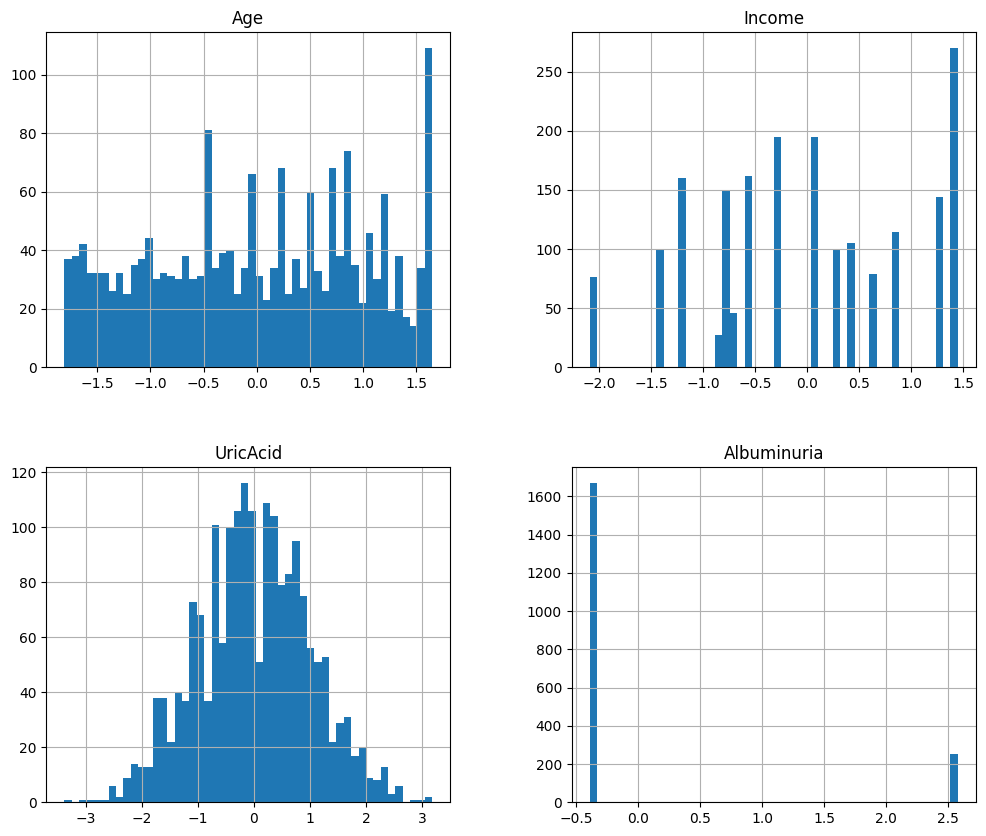

In [49]:
pt = PowerTransformer()
train_set_pt[features_num] = pt.fit_transform(train_set_pt[features_num])
test_set_pt = test_set.copy()
test_set_pt[features_num] = pt.transform(test_set_pt[features_num]) 
train_set_pt[features_num].hist(bins=50, figsize=(12, 10))
plt.show()

#### Separamos en X,y 

In [50]:
X_train_pt= train_set_pt.drop(columns=target)
y_train_pt = train_set_pt[target]
X_test_pt= test_set_pt.drop(columns=target)
y_test_pt = test_set_pt[target]

### Modelado

#### Baseline

In [51]:
model_names = ["Logistic Regression","Arbol de Decision","Random Forest","XGBoost","LightGBM","Catboost", "SVC", "KNN"]
rf_clf = RandomForestClassifier(random_state= 42, class_weight= "balanced")
xgb_clf = XGBClassifier(verbosity= 0, random_state = 42, scale_pos_weight=70/30)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100, class_weight= 'balanced')
lg_clf = LogisticRegression(max_iter = 10000, class_weight= 'balanced')
cat_clf = CatBoostClassifier(random_state= 42, verbose= False, auto_class_weights='Balanced')
tree_clf = DecisionTreeClassifier(random_state= 42, class_weight= "balanced")
svc = SVC(random_state= 42, class_weight='balanced')
knn_clf = KNeighborsClassifier(n_neighbors= 4)

model_set = [rf_clf, xgb_clf, lgb_clf,lg_clf,cat_clf,tree_clf,svc, knn_clf]




In [52]:
#Hacemos un CrossValidation con varios modelos y las features escaladas con PowerTransformer
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    metricas_cv[nombre] = cross_val_score(modelo, X_train_pt, y_train_pt, cv = 5, scoring = "recall")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

RandomForestClassifier(class_weight='balanced', random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(class_weight='balanced', random_state=42, verbose=-100)
LogisticRegression(class_weight='balanced', max_iter=10000)
DecisionTreeClassifier(class_weight='balanced', 

In [53]:
data= []
for model_name, valores in metricas_cv.items():
    data.append({'Modelo': model_name, 'Recall_CV': np.mean(valores)})
df = pd.DataFrame(data)
print(df)
print(f"El ganador es {ganador}")

                Modelo  Recall_CV
0  Logistic Regression   0.815857
1    Arbol de Decision   0.847745
2        Random Forest   0.847756
3              XGBoost   0.931448
4             LightGBM   0.891869
5             Catboost   0.780824
6                  SVC   0.940585
7                  KNN   0.596692
El ganador es SVC


In [54]:
rf_clf = RandomForestClassifier(random_state= 42, class_weight= "balanced")
rf_clf.fit(X_train_pt, y_train_pt)

feature_names = X_train_pt.columns
importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
17,categoria_bloodglucose_Normal,0.155319
24,categoria_trigliceridos_Nivel normal,0.095095
0,Age,0.076986
30,categoria_circunferencia_Normal,0.075317
31,categoria_circunferencia_Riesgo Elevado,0.072121
3,UricAcid,0.066424
28,categoria_hdl_Normal,0.063432
1,Income,0.050306
29,categoria_hdl_Valor_Bajo,0.049596
18,categoria_bloodglucose_Prediabetes,0.040676


#### Optimización de Hiperpárametros

- Voy a hacer un GridSearch de los modelos para mejorar los resultados.

In [55]:
metricas_optimizadas = {}

In [56]:
rf_clf = RandomForestClassifier(random_state= 42)
param_grid_rf = {"n_estimators": [50,100,200],
    "max_depth": [None,20,30],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1,5,10],
    "max_features": ["sqrt","log2",None],
    "class_weight": ["balanced", None],
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= param_grid_rf,
                       cv = 5,
                       scoring = "recall")

rf_grid.fit(X_train_pt, y_train_pt)
print("Random_forest_score:", rf_grid.best_score_)
metricas_optimizadas["Random_Forest"] = rf_grid.best_score_

Random_forest_score: 0.9436039787184825


In [98]:
xgb_clf = XGBClassifier(verbosity= 0, random_state = 42, scale_pos_weight=70/30)
param_grid_xgb= {'n_estimators': [50, 100, 200],
       'learning_rate': [0.01, 0.05, 0.1],
       'max_depth': [3, 5, 7],
       'subsample': [0.6, 0.8, 1.0],
       'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb_clf, 
                        cv = 5,
                        param_grid= param_grid_xgb, 
                        scoring = "recall")


xgb_grid.fit(X_train_pt, y_train_pt)
print("XGB_score:", xgb_grid.best_score_)
metricas_optimizadas["XGBoost"] = xgb_grid.best_score_

XGB_score: 0.9771339347675225


In [58]:
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
param_grid_lgb= {"max_depth": [-1,5,10],
                 "num_leaves": [31, 50],
                "learning_rate": [0.1, 0.01],
                "n_estimators": [100, 200],
                "class_weight": ["balanced", None], 
                "min_child_samples": [20, 30],
                "subsample": [0.8, 1.0],
                "colsample_bytree": [0.8, 1.0]
}

lgb_grid = GridSearchCV(lgb_clf, 
                        cv = 5,
                        param_grid= param_grid_lgb, 
                        scoring = "recall")


lgb_grid.fit(X_train_pt, y_train_pt)
print("LGB_score:", lgb_grid.best_score_)
metricas_optimizadas["LightGBM"] = lgb_grid.best_score_

LGB_score: 0.9406199398565812


In [59]:
tree_clf = DecisionTreeClassifier(random_state= 42)
param_grid_tree = {"criterion": ["gini","entropy"],
                   "splitter": ["best", "random"],
                   "max_depth": [None,20,30,40],
                   "min_samples_split":[2,10,20],
                   "min_samples_leaf":[1,5,10],
                   "max_features": ["sqrt","log2",None],
                   "class_weight": ["balanced", None]
}

tree_grid = GridSearchCV(tree_clf,
                       param_grid= param_grid_tree,
                       cv = 5,
                       scoring = "recall")

tree_grid.fit(X_train_pt, y_train_pt)
print("Arbol_Descición_score:", tree_grid.best_score_)
metricas_optimizadas["Arbol_Descición"] = tree_grid.best_score_

Arbol_Descición_score: 0.9191996298866527


In [60]:
lg_clf = LogisticRegression(random_state=42)
param_grid_lg= {"C":[0.01, 0.1, 1, 10],
                "max_iter":[1000,2000,5000],
                "class_weight":["balanced",None]
}

lg_grid = GridSearchCV(lg_clf,
                       param_grid= param_grid_lg,
                       cv = 5,
                       scoring = "recall")

lg_grid.fit(X_train_pt, y_train_pt)
print("Regresión_Logística_score:", lg_grid.best_score_)
metricas_optimizadas["Regresión_Logística"] = lg_grid.best_score_

Regresión_Logística_score: 0.9375665047420773


In [61]:
knn_clf = KNeighborsClassifier()
param_grid_knn= {"n_neighbors":[3,4,5],
                 "weights":['uniform', 'distance'],
                 "metric":["manhattan","euclidean","chebyshev"]
}

knn_grid = GridSearchCV(knn_clf,
                       param_grid= param_grid_knn,
                       cv = 5,
                       scoring = "recall")

knn_grid.fit(X_train_pt, y_train_pt)
print("KNN_score:", knn_grid.best_score_)
metricas_optimizadas["KNN"] = knn_grid.best_score_

KNN_score: 0.7762202174415914


In [62]:
cat_clf = CatBoostClassifier(random_state= 42, verbose= False)
param_grid_cat= {"iterations": [100, 300], 
    "learning_rate": [0.01, 0.05, 0.1],  
    "depth": [4, 6, 8],  
    "l2_leaf_reg": [1, 3, 5],  
    "bagging_temperature": [0, 1, 10],
    "auto_class_weights": ["Balanced"]
}

cat_grid = GridSearchCV(cat_clf,
                       param_grid= param_grid_cat,
                       cv = 5,
                       scoring = "recall")

cat_grid.fit(X_train_pt, y_train_pt)
print("CatBoost_score:", cat_grid.best_score_)
metricas_optimizadas["CatBoost"] = cat_grid.best_score_

CatBoost_score: 0.9436849410131852


In [63]:
svc = SVC(random_state= 42)
param_grid_svc= {"C":[0.01, 0.1, 1, 10, 100],
                 "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
                 "gamma":['scale', 'auto'],
                 "class_weight":["balanced",None]
}

svc_grid = GridSearchCV(svc,
                       param_grid= param_grid_svc,
                       cv = 5,
                       scoring = "recall")

svc_grid.fit(X_train_pt, y_train_pt)
print("SVC_score:", svc_grid.best_score_)
metricas_optimizadas["SVC"] = svc_grid.best_score_

SVC_score: 0.9619592875318066


In [66]:
metricas_optimizadas

{'Random_Forest': 0.9436039787184825,
 'XGBoost': 0.9771339347675225,
 'LightGBM': 0.9406199398565812,
 'Arbol_Descición': 0.9191996298866527,
 'Regresión_Logística': 0.9375665047420773,
 'KNN': 0.7762202174415914,
 'CatBoost': 0.9436849410131852,
 'SVC': 0.9619592875318066}

- El mejor modelo una vez optimizado los hiperparámetros es el XGBoost, consiguiendo un recall de 0.97 contra el train. 

In [67]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}
0.9771339347675225


In [68]:
# Guardamos el mejor modelo en un archivo
dump(xgb_grid, 'modelo_entrenado_xgb_grid.joblib')

['modelo_entrenado_xgb_grid.joblib']

### Evaluación contra Test

In [99]:
y_pred = xgb_grid.best_estimator_.predict(X_test_pt)
print(classification_report(y_test_pt, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86       316
           1       0.69      0.96      0.80       165

    accuracy                           0.84       481
   macro avg       0.83      0.87      0.83       481
weighted avg       0.88      0.84      0.84       481



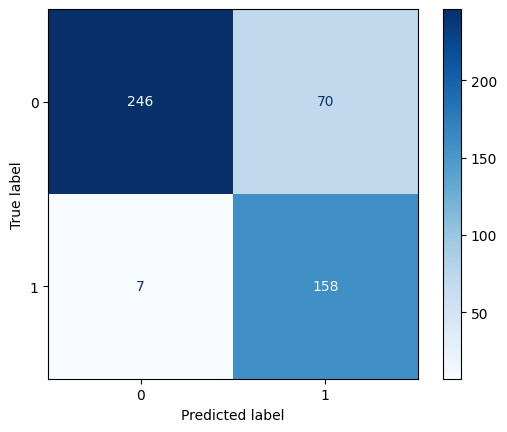

In [100]:
ConfusionMatrixDisplay.from_predictions(y_test_pt, y_pred,cmap="Blues")

AUC-ROC: 0.9519658611430762


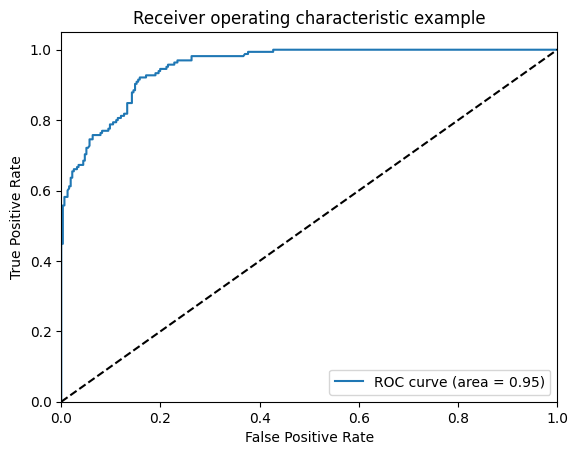

In [101]:
probabilidades = xgb_grid.predict_proba(X_test_pt)[:, 1]

fpr, tpr, _ = roc_curve(y_test_pt, probabilidades)
roc_auc = auc(fpr, tpr)

print("AUC-ROC:", roc_auc)

# Visualización de la Curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


#### Equilibrado

In [86]:
# Hago el Sobremuestreo para ver si equilibrando un poco las clases me mejora el resultado contra el test
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pt, y_train_pt)

In [87]:
# Entrenar el modelo con los datos sobremuestreados
modelo_smote = xgb_grid
modelo_smote.fit(X_train_smote, y_train_smote)

# Realizar predicciones y evaluar el modelo
y_pred_smote = modelo_smote.predict(X_test_pt)
print(classification_report(y_test_pt, y_pred_smote))

              precision    recall  f1-score   support

           0       1.00      0.38      0.55       316
           1       0.46      1.00      0.63       165

    accuracy                           0.59       481
   macro avg       0.73      0.69      0.59       481
weighted avg       0.81      0.59      0.58       481



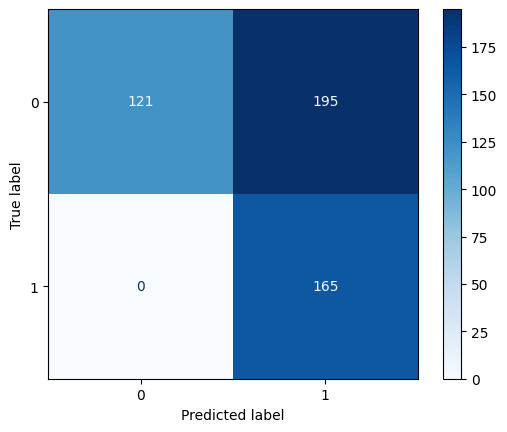

In [102]:
ConfusionMatrixDisplay.from_predictions(y_test_pt, y_pred_smote,cmap="Blues")

In [88]:
#Pruebo bajar el umbral para ver si mejora el recall de la clase 1 sin que me suba demasiado los falsos postivos
y_pred_umbral =probabilidades >= 0.43
reporte = classification_report(y_test_pt, y_pred_umbral, target_names=['Clase 0', 'Clase 1'])
print(reporte)

              precision    recall  f1-score   support

     Clase 0       1.00      0.18      0.31       316
     Clase 1       0.39      1.00      0.56       165

    accuracy                           0.46       481
   macro avg       0.70      0.59      0.44       481
weighted avg       0.79      0.46      0.40       481



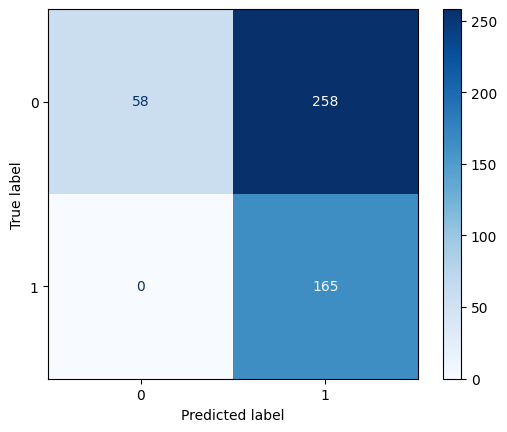

In [89]:
ConfusionMatrixDisplay.from_predictions(y_test_pt, y_pred_umbral,cmap="Blues")

### Análisis de Errores

In [90]:
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,

In [91]:
test_set_copy["real"] = test_set_copy["MetabolicSyndrome"]
test_set_copy["Pred"]= y_pred
errores = test_set_copy.drop(columns="MetabolicSyndrome")
errores

,Age,Sex,Marital,Income,Race,Albuminuria,UricAcid,categoria_bmi,categoria_bloodglucose,categoria_trigliceridos,categoria_hdl,categoria_circunferencia,real,Pred
2221,21,Male,Single,2000.000000,Asian,0,6.0,Normal,Normal,Nivel normal,Normal,Normal,0,0
1075,47,Male,Married,2500.000000,White,0,6.3,Obesidad,Prediabetes,Niveles ligeramente altos,Normal,Riesgo Elevado,1,1
1236,80,Female,Married,2500.000000,White,0,4.5,Obesidad,Normal,Niveles altos,Normal,Riesgo Elevado,1,1
276,42,Female,Separated,4025.151016,Other,0,3.6,Normal,Normal,Nivel normal,Normal,Normal,0,0
1042,20,Female,Single,300.000000,White,0,7.0,Obesidad,Prediabetes,Nivel normal,Normal,Riesgo Elevado,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,32,Male,NaN,3500.000000,MexAmerican,0,5.8,Obesidad,Normal,Nivel normal,Normal,Riesgo Elevado,0,0
1671,20,Male,Single,2500.000000,Black,0,9.1,Obesidad,Normal,Nivel normal,Normal,Riesgo Elevado,0,1
697,54,Male,Single,5400.000000,White,0,6.8,Obesidad,Prediabetes,Nivel normal,Valor_Bajo,Riesgo Elevado,1,1
1644,22,Male,NaN,2500.000000,Hispanic,0,6.2,Sobrepeso,Prediabetes,Nivel normal,Valor_Bajo,Normal,0,0


In [92]:
errores[(errores["real"]==1) & (errores["Pred"]==0)]

,Age,Sex,Marital,Income,Race,Albuminuria,UricAcid,categoria_bmi,categoria_bloodglucose,categoria_trigliceridos,categoria_hdl,categoria_circunferencia,real,Pred
1929,61,Male,Married,1700.000000,Hispanic,0,4.9,Obesidad,Normal,Niveles ligeramente altos,Normal,Normal,1,0
561,51,Female,Divorced,4025.151016,White,0,3.1,Sobrepeso,Normal,Nivel normal,Valor_Bajo,Riesgo Elevado,1,0
1390,80,Female,Married,1000.000000,White,0,4.2,Normal,Normal,Nivel normal,Normal,Riesgo Elevado,1,0
104,23,Male,Single,2000.000000,Asian,0,5.5,Obesidad,Normal,Nivel normal,Normal,Riesgo Elevado,1,0
1357,32,Male,Married,5400.000000,Black,0,6.8,Sobrepeso,Normal,Niveles altos,Normal,Normal,1,0
1049,38,Female,Married,2500.000000,White,0,4.2,Normal,Prediabetes,Nivel normal,Valor_Bajo,Normal,1,0
1845,36,Male,NaN,8200.000000,White,0,4.9,Sobrepeso,Prediabetes,Nivel normal,Normal,Riesgo Elevado,1,0
598,37,Male,Married,9000.000000,Hispanic,0,6.4,Normal,Prediabetes,Niveles ligeramente altos,Normal,Normal,1,0
1047,43,Male,Married,300.000000,White,0,4.4,Normal,Diabetes,Niveles altos,Normal,Normal,1,0
1225,36,Female,Married,8200.000000,White,0,3.9,Sobrepeso,Normal,Nivel normal,Valor_Bajo,Riesgo Elevado,1,0


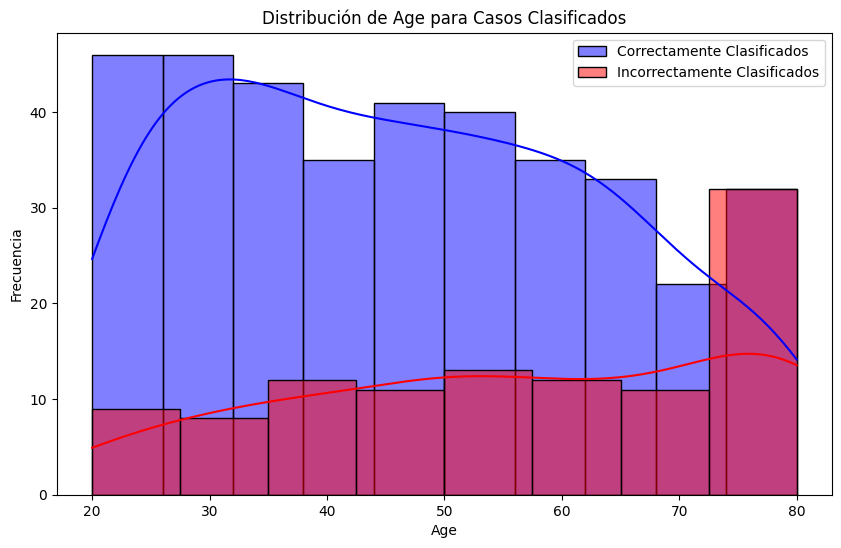

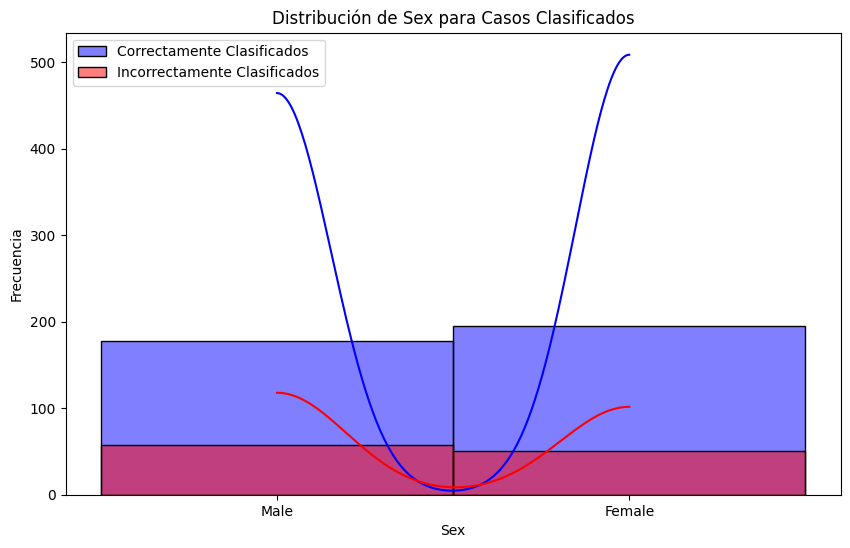

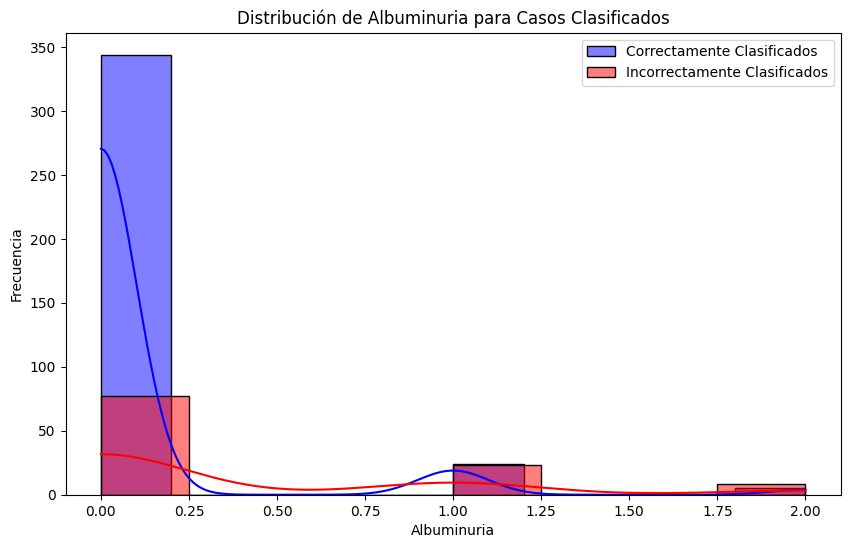

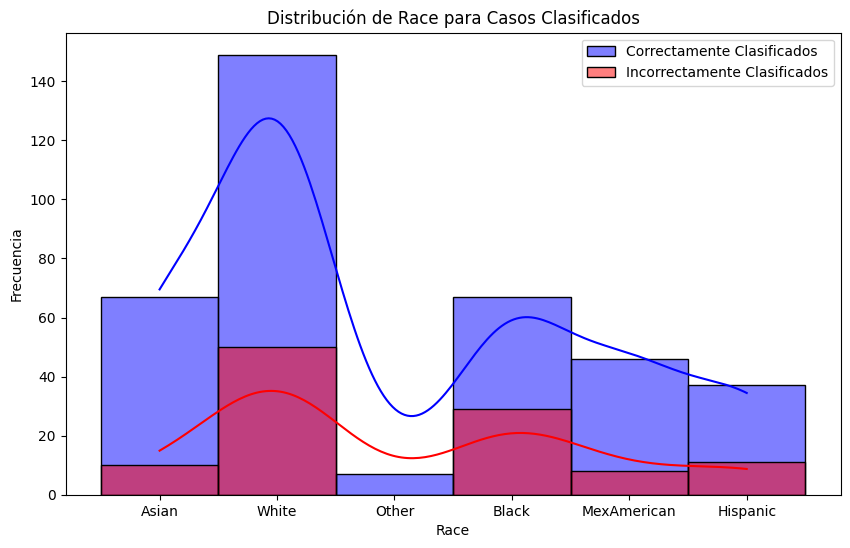

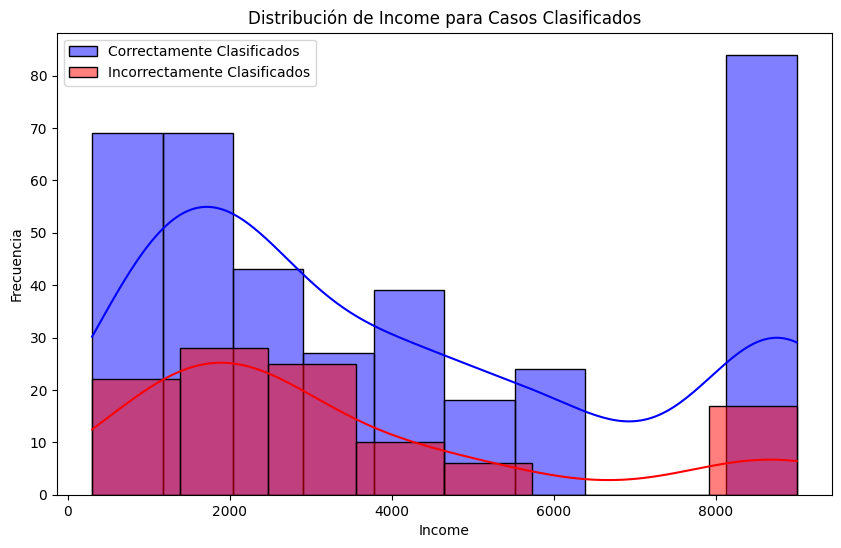

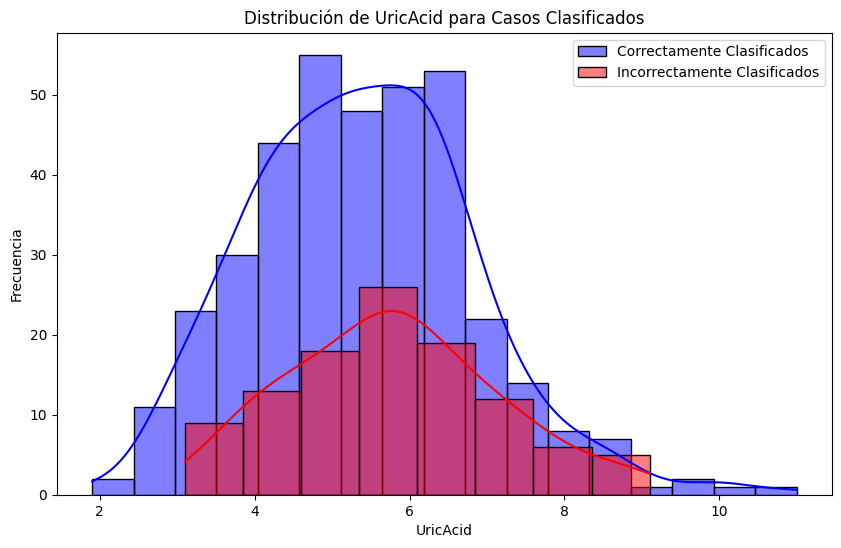

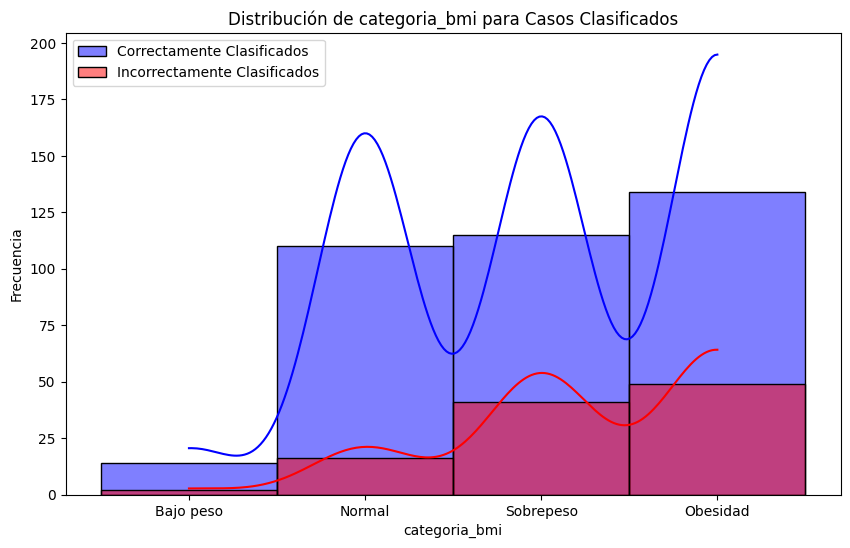

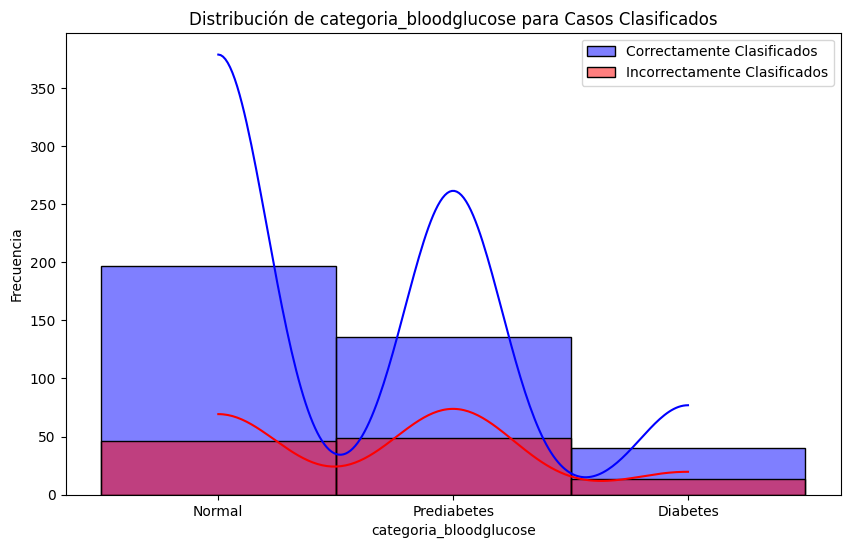

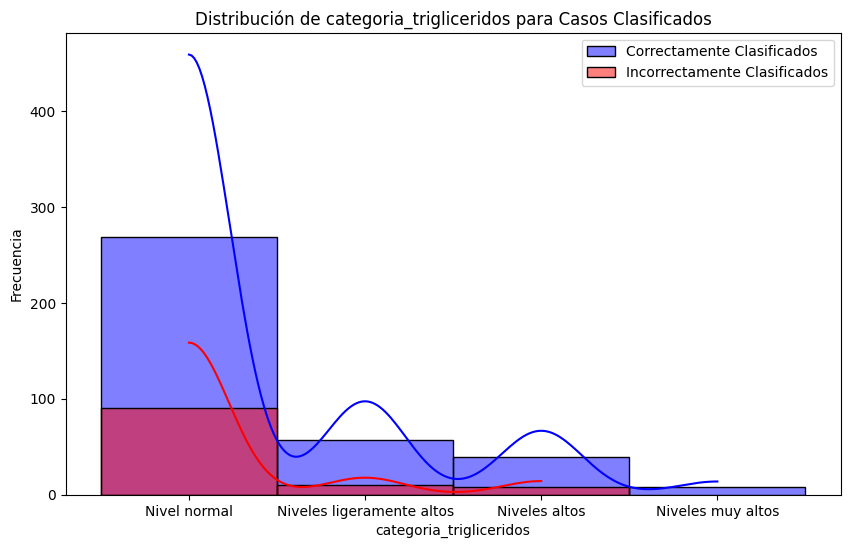

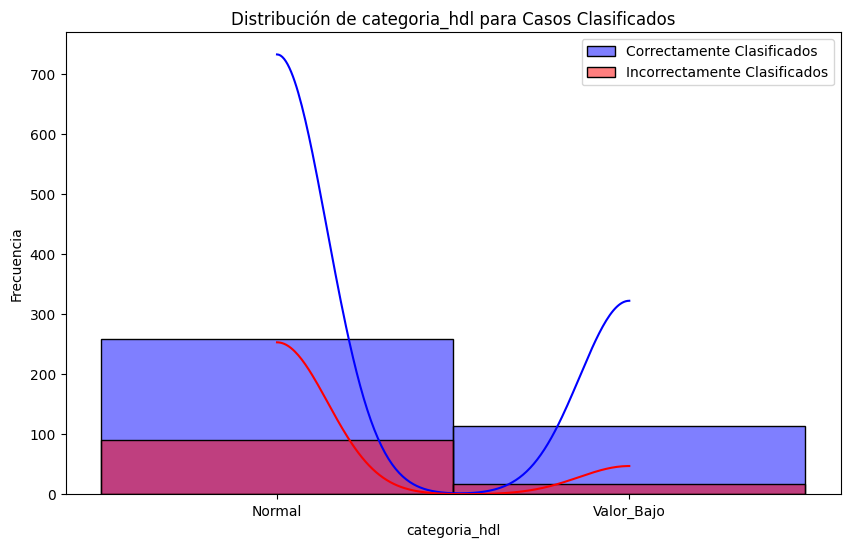

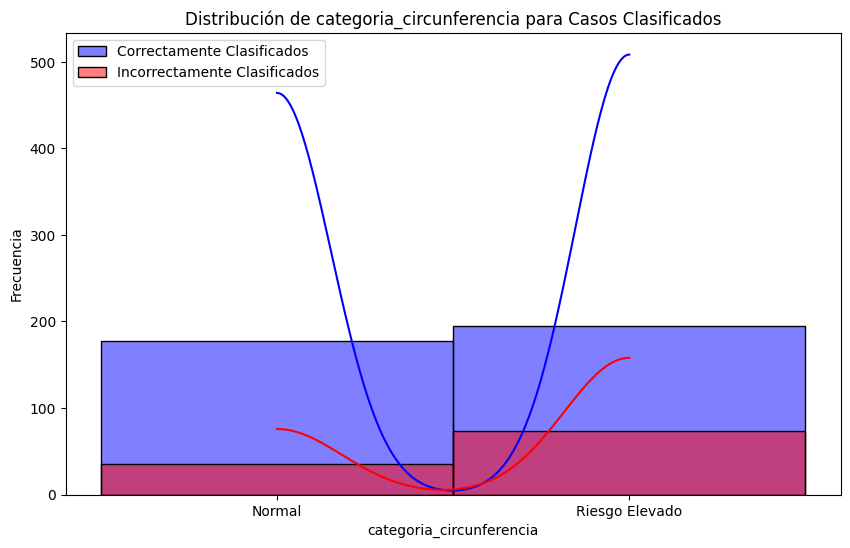

In [93]:
# Supongamos que df es tu DataFrame con las predicciones
# Filtrar datos correctamente clasificados y mal clasificados
correctos = errores[errores['real'] == errores['Pred']]
incorrectos = errores[errores['real'] != errores['Pred']]

# Definir las características a visualizar
caracteristicas = ['Age','Sex','Albuminuria','Race','Income','UricAcid','categoria_bmi', 'categoria_bloodglucose', 'categoria_trigliceridos', 'categoria_hdl','categoria_circunferencia']

# Visualizar las distribuciones para las características seleccionadas
for caracteristica in caracteristicas:
    plt.figure(figsize=(10, 6))
    sns.histplot(correctos[caracteristica], label='Correctamente Clasificados', color='blue', kde=True)
    sns.histplot(incorrectos[caracteristica], label='Incorrectamente Clasificados', color='red', kde=True)
    plt.title(f'Distribución de {caracteristica} para Casos Clasificados')
    plt.xlabel(caracteristica)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()